# Ring broadcast experiment

In this experiment, N ranks perform a ring broadcast. We measure the duration of the individual calls to `MPI_Recv` and `MPI_Send`.

In [1]:
import io
import os
import zipfile
import pandas
import yaml
from plotnine import *
import plotnine
import sys
plotnine.options.figure_size = (12, 8)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # removing annoying Pandas warning

def read_csv(archive_name, csv_name, columns=None, filter_func=lambda x: x, usecols=None):
    archive = zipfile.ZipFile(archive_name)
    df= pandas.read_csv(io.BytesIO(filter_func(archive.read(csv_name))), names=columns)
    df.columns = df.columns.str.strip()
    return df

def get_yaml(archive_name, yaml_name):
    archive = zipfile.ZipFile(archive_name)
    return yaml.load(io.BytesIO(archive.read(yaml_name)))

In [2]:
archive = 'ring/2/grenoble_2020-08-18_1944813.zip'
df = read_csv(archive, 'result.csv')
print(len(df))
df.head()

368640


,function,rank,size,timestamp,duration
0,MPI_Send,0,8584,0.000002,0.000050
1,MPI_Recv,0,8584,0.047714,0.000009
2,MPI_Send,0,8584,0.047727,0.000004
3,MPI_Recv,0,8584,0.058287,0.000002
4,MPI_Send,0,8584,0.058291,0.000003


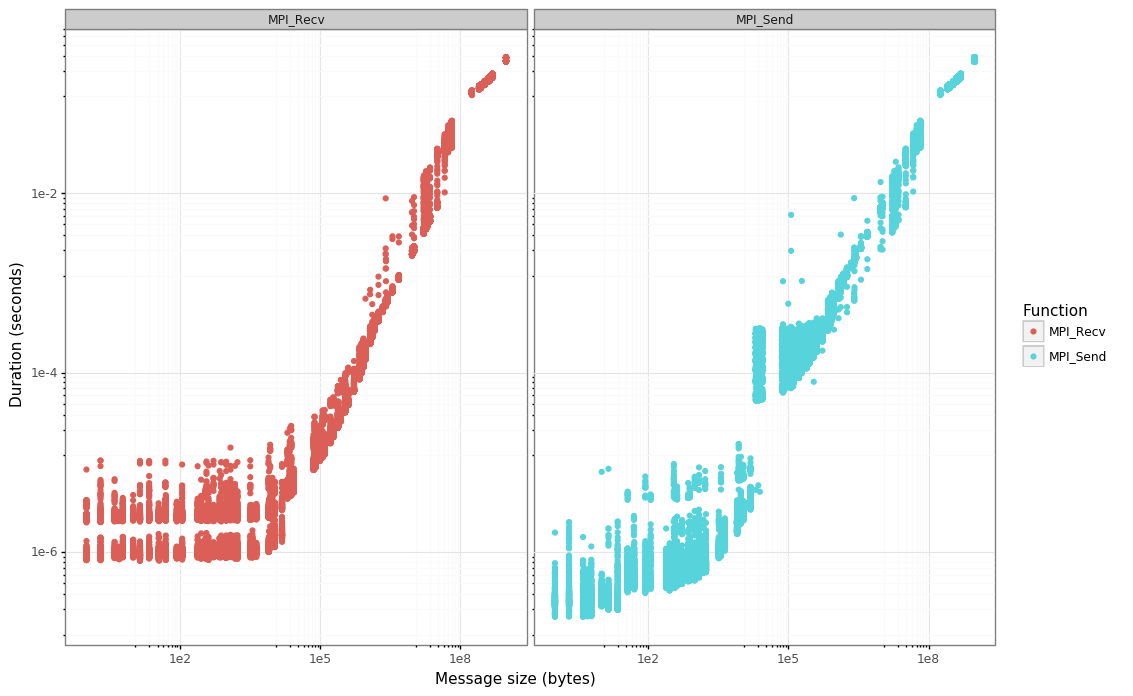

<ggplot: (8793779352303)>

In [3]:
(ggplot(df[(df['rank'] > 0) & (df['rank'] < 10)])
    + aes(x='size', y='duration', color='function')
    + geom_point() 
    + theme_bw()
    + scale_x_log10()
    + scale_y_log10()
    + facet_wrap('function')
    + labs(x='Message size (bytes)', y='Duration (seconds)', color='Function')
)

In [4]:
df['rank+1'] = df['rank'] + 1
df['start'] = df['timestamp']
df['end'] = df['start'] + df['duration']

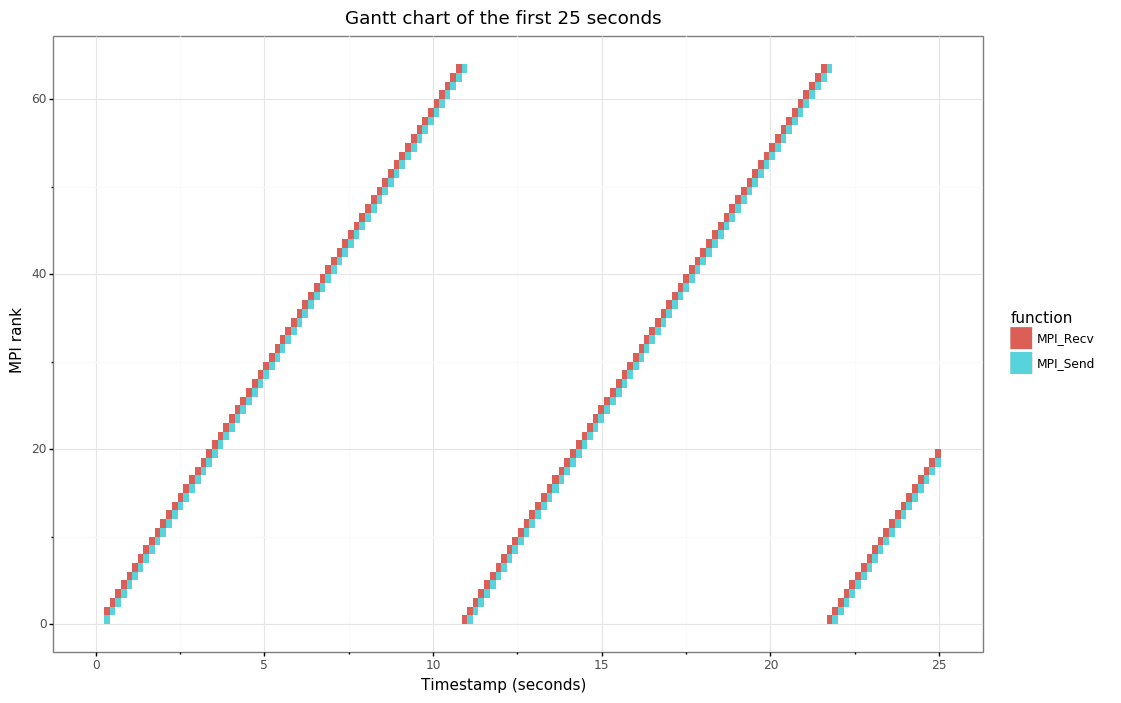

<ggplot: (-9223363242980107099)>

In [5]:
def plot(df):
    return (ggplot(df)
        + geom_rect(aes(xmin='start', xmax='end', ymin='rank', ymax='rank+1',fill='function'))
        + theme_bw()
        + labs(x='Timestamp (seconds)', y='MPI rank', color='Function')
    )

plot(df[df['start'] < 25]) + ggtitle('Gantt chart of the first 25 seconds')

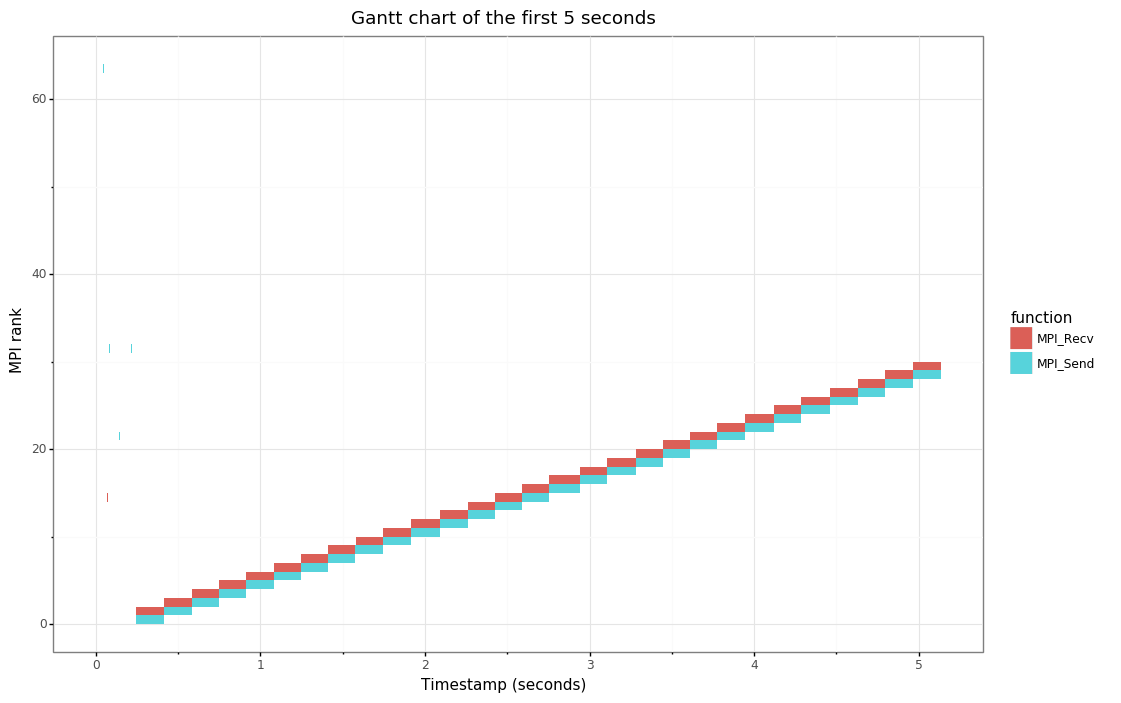

<ggplot: (-9223363243084787996)>

In [6]:
plot(df[df['start'] < 5]) + ggtitle('Gantt chart of the first 5 seconds')

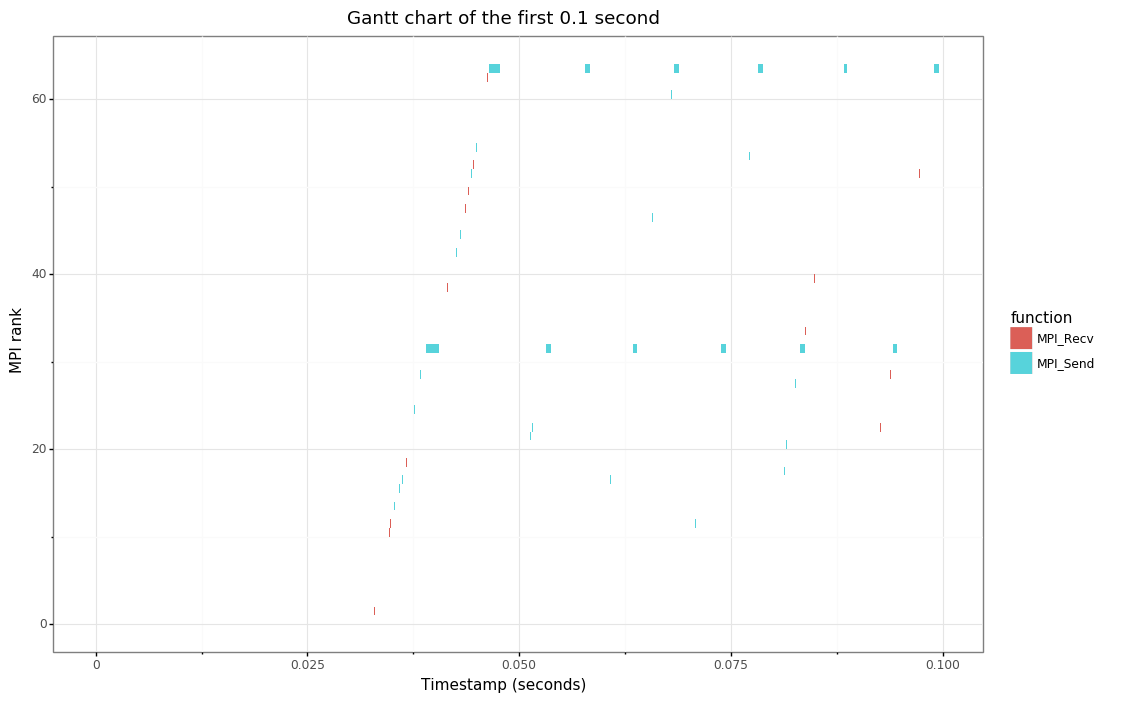

<ggplot: (-9223363243082202410)>

In [7]:
plot(df[df['start'] < 0.1]) + ggtitle('Gantt chart of the first 0.1 second')

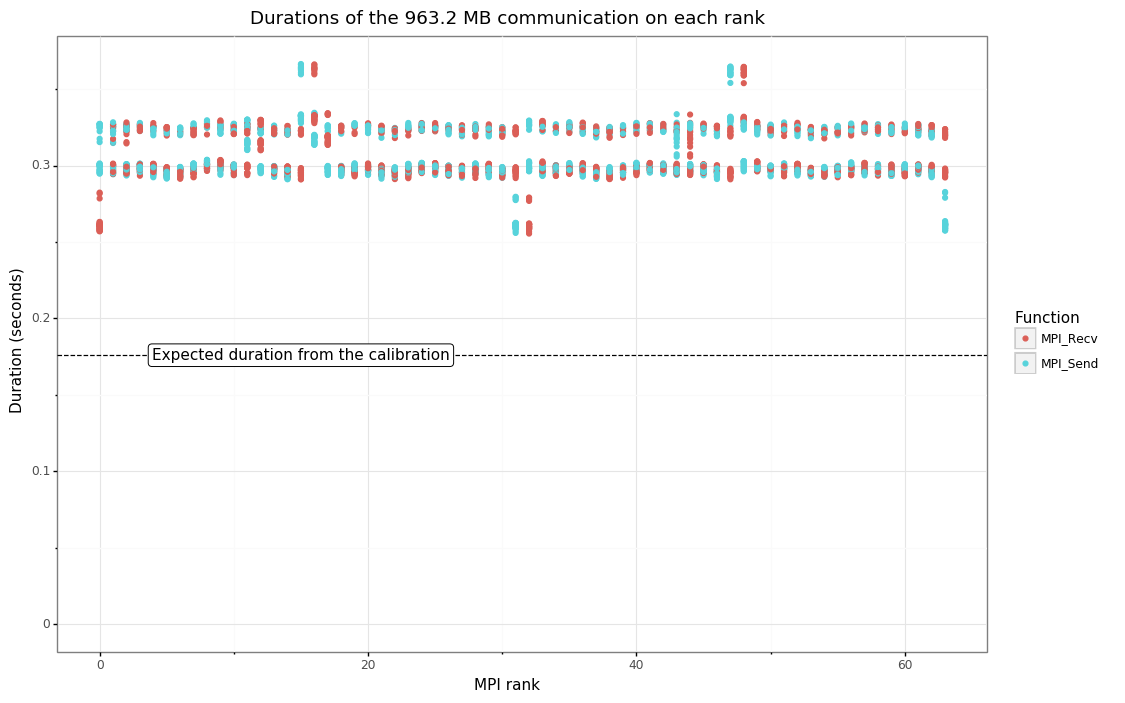

<ggplot: (-9223363243084625520)>

In [8]:
bw  = 25*1e9
lat = 0.1*1e-6
bw_factor = 0.219
lat_factor = 0
size = df['size'].max()
theoretical_duration = size/(bw*bw_factor) + lat*lat_factor

(ggplot(df[df['size'] == size])
    + aes(x='rank', y='duration', color='function')
    + geom_point() 
    + theme_bw()
    + expand_limits(y=0)
    + geom_hline(yintercept=theoretical_duration, linetype='dashed')
    + labs(x='MPI rank', y='Duration (seconds)', color='Function')
    + annotate('label', x=15, y=theoretical_duration, label='Expected duration from the calibration')
    + ggtitle(f'Durations of the {size*1e-6:.1f} MB communication on each rank')
)

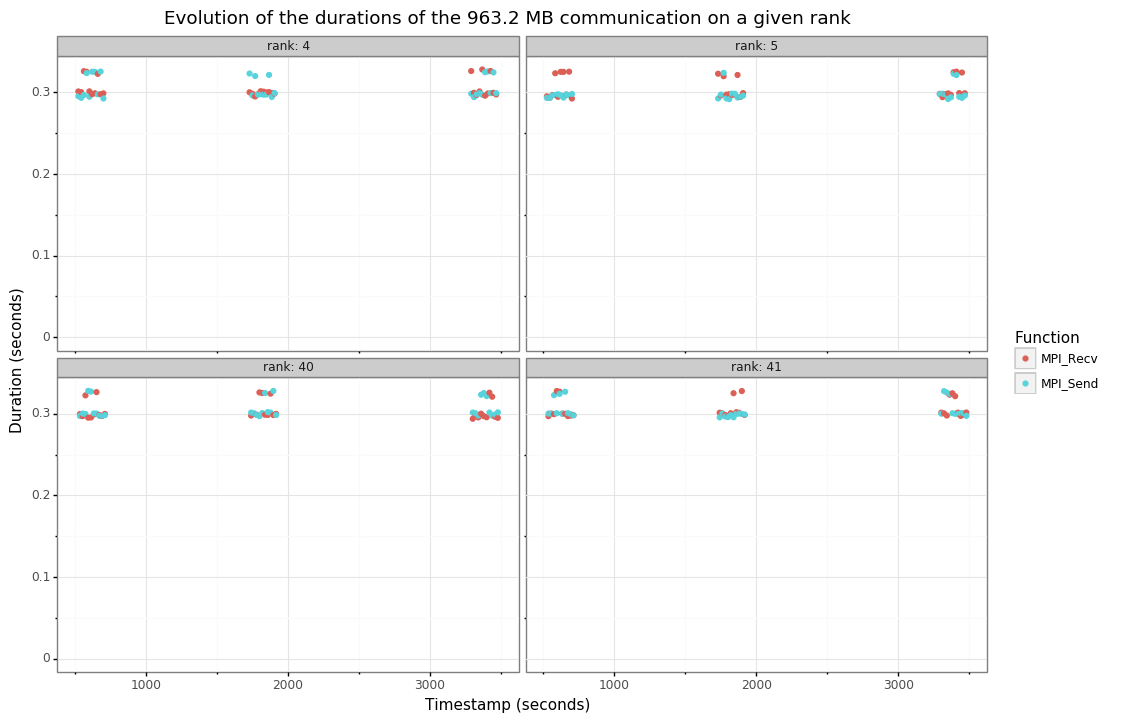

<ggplot: (8793772607166)>

In [9]:
(ggplot(df[(df['size'] == size) & (df['rank'].isin({4,5,40,41}))])
    + aes(x='timestamp', y='duration', color='function')
    + geom_point()
    + theme_bw()
    + expand_limits(y=0)
    + facet_wrap('rank', labeller='label_both')
    + labs(x='Timestamp (seconds)', y='Duration (seconds)', color='Function')
    + ggtitle(f'Evolution of the durations of the {size*1e-6:.1f} MB communication on a given rank')
)

278959324


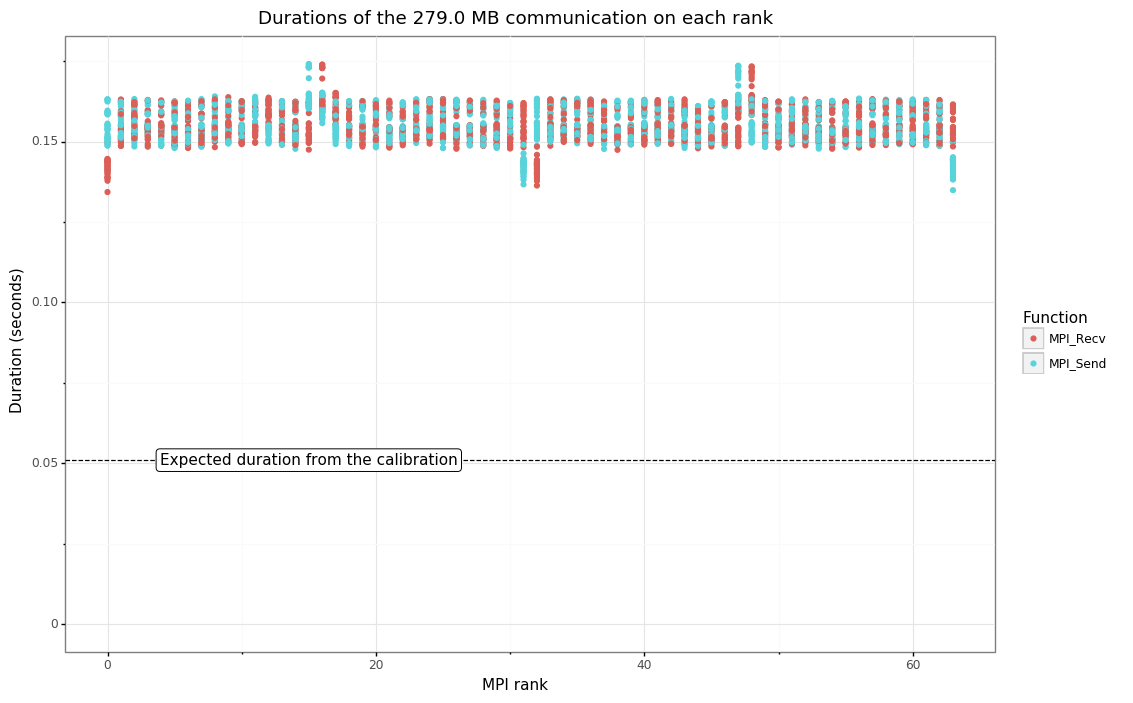

<ggplot: (-9223363243079966930)>

In [10]:
bw  = 25*1e9
lat = 0.1*1e-6
bw_factor = 0.219
lat_factor = 0
size = df[df['size'] < 3e8]['size'].max()
print(size)
theoretical_duration = size/(bw*bw_factor) + lat*lat_factor

(ggplot(df[df['size'] == size])
    + aes(x='rank', y='duration', color='function')
    + geom_point() 
    + theme_bw()
    + expand_limits(y=0)
    + geom_hline(yintercept=theoretical_duration, linetype='dashed')
    + labs(x='MPI rank', y='Duration (seconds)', color='Function')
    + annotate('label', x=15, y=theoretical_duration, label='Expected duration from the calibration')
    + ggtitle(f'Durations of the {size*1e-6:.1f} MB communication on each rank')
)

## Monitoring

In [11]:
import cashew
print(cashew.__git_version__)
from cashew import archive_extraction

c0a430e3a498fc690b6244ca9909444040c28128


In [12]:
monitoring = archive_extraction.read_monitoring(archive)
monitoring['date'] = pandas.to_datetime(monitoring['start_time'], unit='s').astype(str)
for date in monitoring['date'].unique():
    monitoring.loc[monitoring['date'] == date, 'real_start_time'] = monitoring[monitoring['date'] == date]['timestamp'].min()
monitoring['start_exp'] -= monitoring['real_start_time']
monitoring['stop_exp'] -= monitoring['real_start_time']
monitoring['timestamp'] -= monitoring['real_start_time']
monitoring['cpu_id'] = monitoring['node'].astype(str) + ':' + monitoring['cpu'].astype(str)
monitoring['in_exp'] = (monitoring['timestamp'] > monitoring['start_exp'] + 60) & (monitoring['timestamp'] < monitoring['stop_exp'] - 60)
monitoring['hostname'] = monitoring['cluster'] + '-' + monitoring['node'].astype(str)
print(len(monitoring))
monitoring.head()

477952


,timestamp,cluster,node,jobid,start_time,expfile_hash,value,cpu,core,kind,start_exp,stop_exp,date,real_start_time,cpu_id,in_exp,hostname
0,0.000000,dahu,2,1944813,1597762759,199480a2b88da84036d4eb9076b659fec9b511c0f6ebb4...,1.000012,0,0,frequency,34.706461,3761.898819,2020-08-18 14:59:19,1.597770e+09,2:0,False,dahu-2
1,1.008256,dahu,2,1944813,1597762759,199480a2b88da84036d4eb9076b659fec9b511c0f6ebb4...,3.031182,0,0,frequency,34.706461,3761.898819,2020-08-18 14:59:19,1.597770e+09,2:0,False,dahu-2
2,2.017060,dahu,2,1944813,1597762759,199480a2b88da84036d4eb9076b659fec9b511c0f6ebb4...,3.057714,0,0,frequency,34.706461,3761.898819,2020-08-18 14:59:19,1.597770e+09,2:0,False,dahu-2
3,3.025220,dahu,2,1944813,1597762759,199480a2b88da84036d4eb9076b659fec9b511c0f6ebb4...,1.719323,0,0,frequency,34.706461,3761.898819,2020-08-18 14:59:19,1.597770e+09,2:0,False,dahu-2
4,4.033389,dahu,2,1944813,1597762759,199480a2b88da84036d4eb9076b659fec9b511c0f6ebb4...,3.164227,0,0,frequency,34.706461,3761.898819,2020-08-18 14:59:19,1.597770e+09,2:0,False,dahu-2


In [13]:
monitoring[monitoring.in_exp].groupby(['hostname', 'cpu', 'kind'])[['value']].mean()

value
hostname cpu kind                  
dahu-18  0   frequency     1.925837
             temperature  66.363146
         1   frequency     1.925679
             temperature  51.483153
dahu-2   0   frequency     1.925893
             temperature  66.706412
         1   frequency     1.925568
             temperature  56.174438

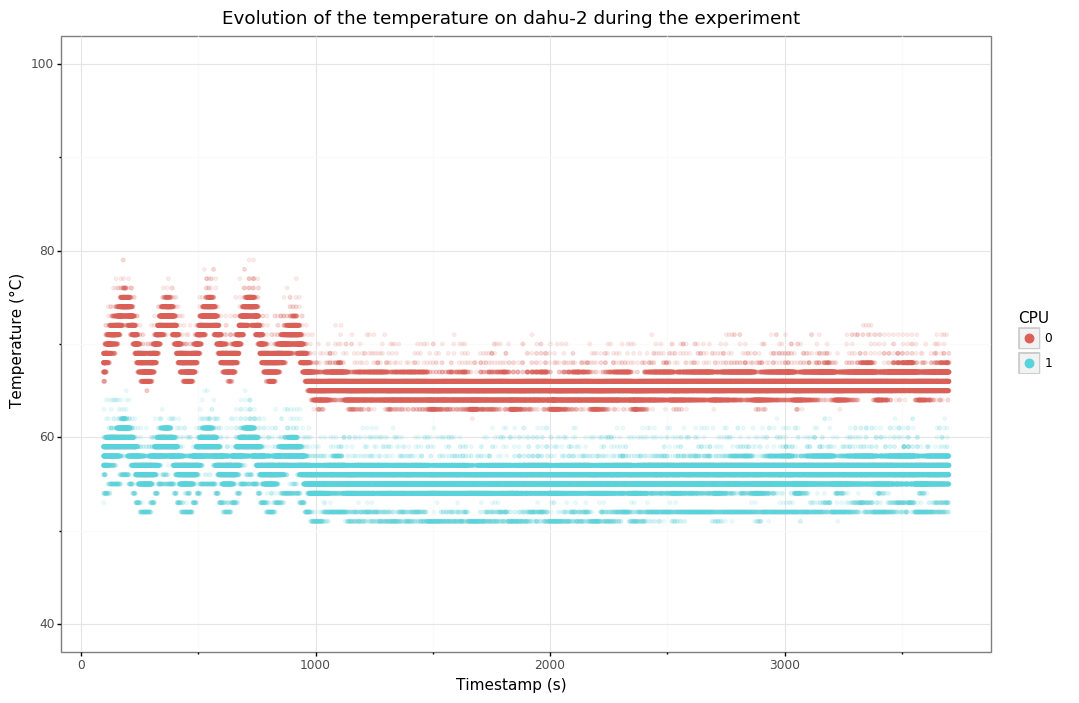

<ggplot: (-9223363243091278283)>


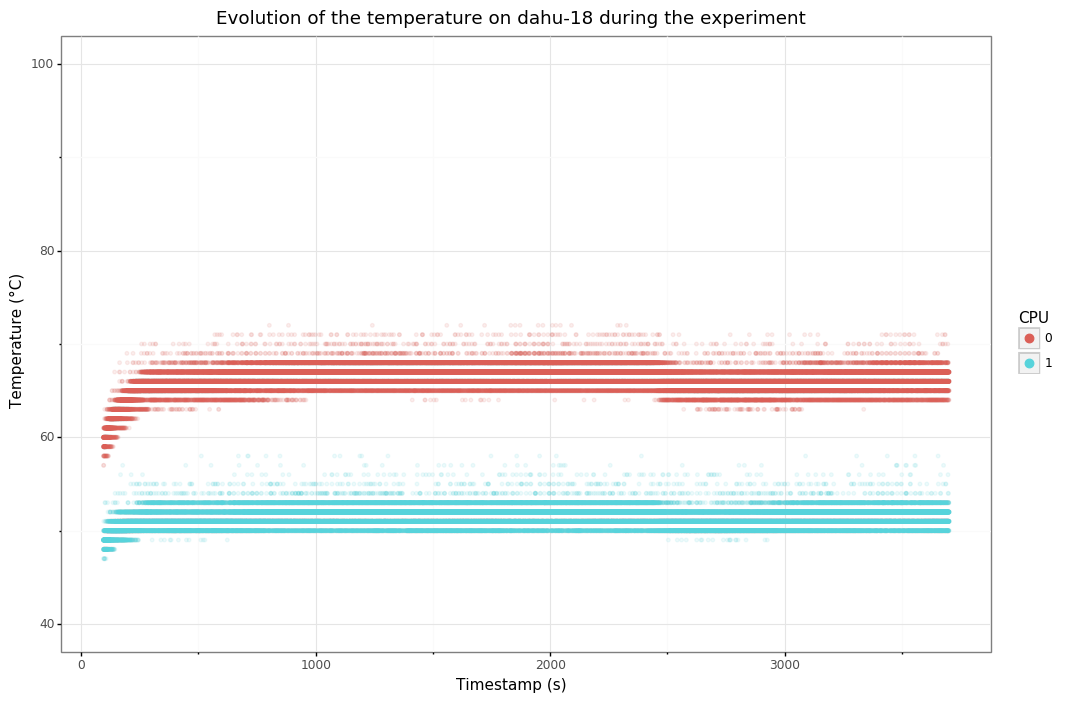

<ggplot: (-9223363243079961533)>


In [14]:
for node in sorted(monitoring.node.unique()):
    print(ggplot(monitoring[(monitoring.in_exp) & (monitoring.node == node) & (monitoring.kind == 'temperature')])
        + aes(x='timestamp', y='value', color='factor(cpu)')
        + geom_point(alpha=0.1, size=1)
        + theme_bw()
        + labs(x='Timestamp (s)', y='Temperature (°C)', color='CPU')
        + ggtitle(f'Evolution of the temperature on dahu-{node} during the experiment')
        + guides(colour = guide_legend(override_aes = {'alpha': 1, 'size': 3}))
        + expand_limits(y=[40, 100])
    )

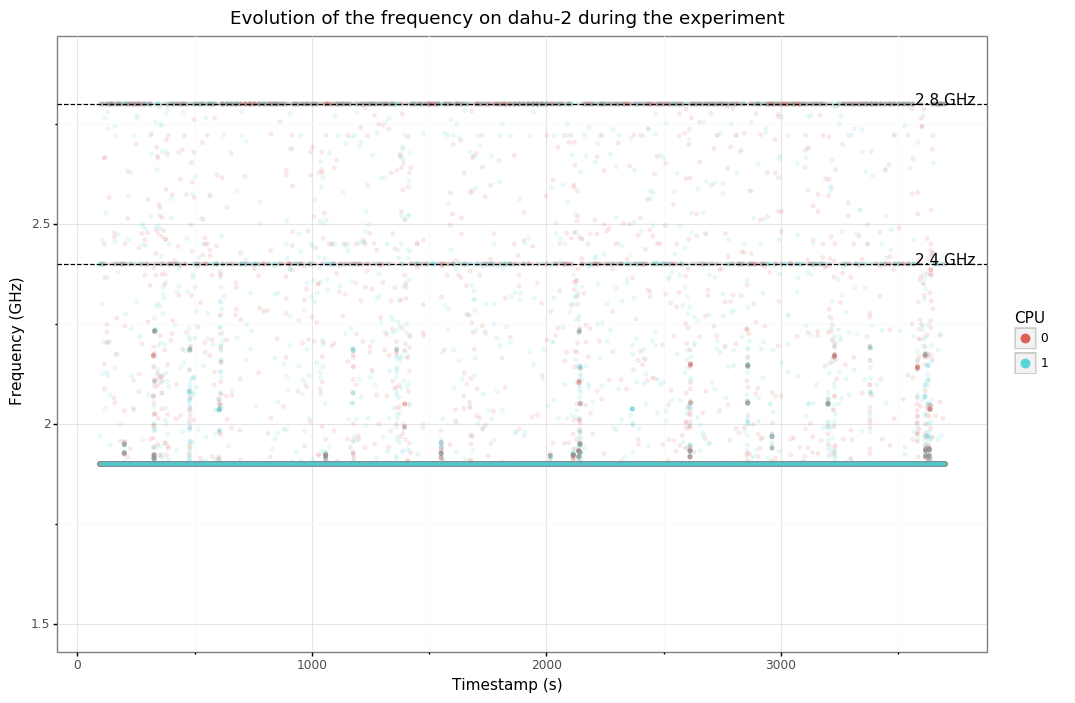

<ggplot: (-9223363243082130614)>


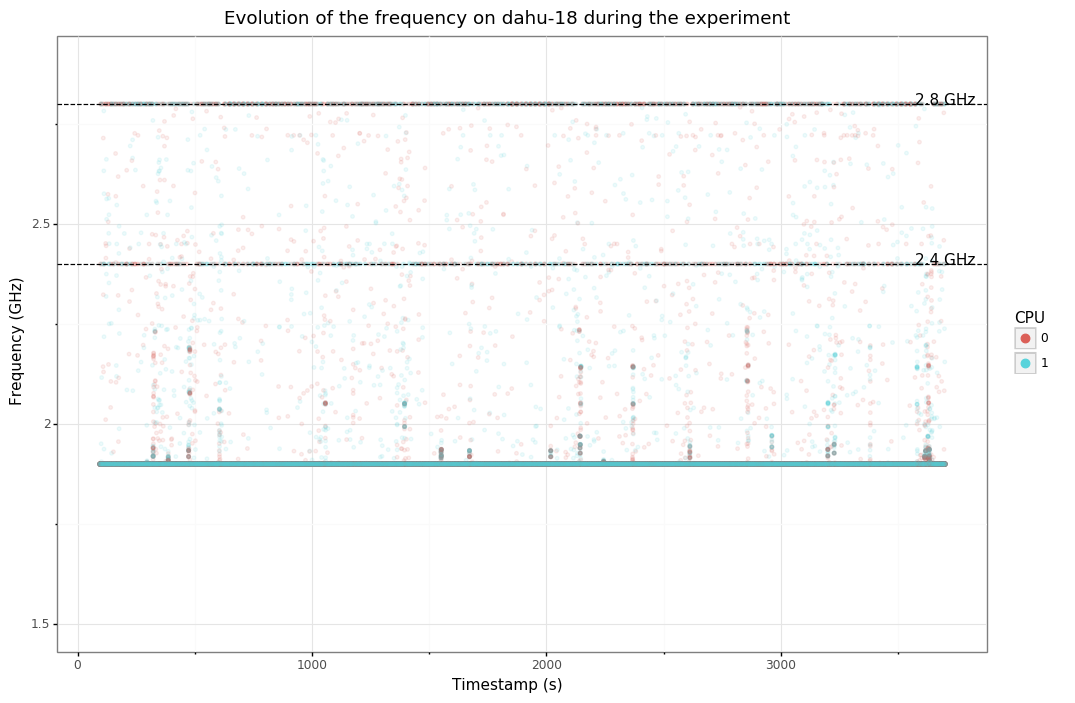

<ggplot: (-9223363243091334456)>


In [15]:
for node in sorted(monitoring.node.unique()):
    print(ggplot(monitoring[(monitoring.in_exp) & (monitoring.node == node) & (monitoring.kind == 'frequency')])
        + aes(x='timestamp', y='value', color='factor(cpu)')
        + geom_point(alpha=0.1, size=1)
        + theme_bw()
        + labs(x='Timestamp (s)', y='Frequency (GHz)', color='CPU')
        + ggtitle(f'Evolution of the frequency on dahu-{node} during the experiment')
        + guides(colour = guide_legend(override_aes = {'alpha': 1, 'size': 3}))
        + geom_hline(yintercept=2.4, linetype='dashed')
        + annotate('text', label='2.4 GHz', x=monitoring[monitoring.in_exp].timestamp.max(), y=2.41)
        + geom_hline(yintercept=2.8, linetype='dashed')
        + annotate('text', label='2.8 GHz', x=monitoring[monitoring.in_exp].timestamp.max(), y=2.81)
        + expand_limits(y=[1.5, 2.9])
    )